# SRE ReAct agent with custom schema and RAG (to store mitigation plans)

This notebook implements an intelligent Site Reliability Engineering (SRE) agent that automatically diagnoses Kubernetes incidents and generates mitigation plans. The agent uses a ReAct (Reasoning + Acting) framework powered by LangGraph to:

- **Investigate incidents** using kubectl tools through MCP (Model Context Protocol) servers
- **Analyze cluster state** and extract meaningful insights from Kubernetes resources
- **Generate structured diagnosis** with detailed reasoning and root cause analysis
- **Create mitigation plans** by leveraging ChromaDB RAG to search for similar past incidents
- **Provide comprehensive reports** with step-by-step remediation guidance

In [1]:
from dotenv import load_dotenv
import os

# Set env variables from file
load_dotenv()

True

In [2]:
chromaDB_path = os.environ.get("CHROMADB_STORAGE_PATH")

## Testing the RAG (ChromaDB)

In [3]:
from chromadb import PersistentClient

chroma_client = PersistentClient(path=chromaDB_path)

incidents_collection = chroma_client.get_or_create_collection("incidents")

# Get all the docs in the collection
incidents_collection.get()


{'ids': [],
 'embeddings': None,
 'documents': [],
 'uris': None,
 'included': ['metadatas', 'documents'],
 'data': None,
 'metadatas': []}

## Building SRE ReAct agent

In [4]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

gpt5 = ChatOpenAI(model="gpt-5")
gpt5mini = ChatOpenAI(model="gpt-5-mini")
gemini = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=os.getenv("GOOGLEAI_API_KEY") # Google AI Studio free api key
)

In [5]:
from langchain_mcp_adapters.client import MultiServerMCPClient

chromaDB_path = os.environ.get("CHROMADB_STORAGE_PATH")

client = MultiServerMCPClient(
    {
        "kubernetes" : {
            "command": "npx",
            "args": ["mcp-server-kubernetes"],
            "transport": "stdio",
            "env": {
                "ALLOW_ONLY_NON_DESTRUCTIVE_TOOLS": "true"
            }
        },
        "chroma": {
            "command": "uvx",
            "transport": "stdio",
            "args": [
                "chroma-mcp",
                "--client-type",
                "persistent",
                "--data-dir",
                str(chromaDB_path)
            ]
        }
    }
)

# NB: The cluster has to be running otherwise the tools won't be available
mcp_tools = await client.get_tools()

In [6]:
#list all the tools
for tool in mcp_tools:
    print(f"🔧 {tool.name}")

🔧 kubectl_get
🔧 kubectl_describe
🔧 kubectl_apply
🔧 kubectl_create
🔧 kubectl_logs
🔧 kubectl_scale
🔧 kubectl_patch
🔧 kubectl_rollout
🔧 kubectl_context
🔧 explain_resource
🔧 install_helm_chart
🔧 upgrade_helm_chart
🔧 port_forward
🔧 stop_port_forward
🔧 exec_in_pod
🔧 list_api_resources
🔧 ping
🔧 chroma_list_collections
🔧 chroma_create_collection
🔧 chroma_peek_collection
🔧 chroma_get_collection_info
🔧 chroma_get_collection_count
🔧 chroma_modify_collection
🔧 chroma_fork_collection
🔧 chroma_delete_collection
🔧 chroma_add_documents
🔧 chroma_query_documents
🔧 chroma_get_documents
🔧 chroma_update_documents
🔧 chroma_delete_documents


In [7]:
# Tools allowed
tools_allowed = ["kubectl_get", "kubectl_describe", "kubectl_logs", "explain_resource", "list_api_resources", "ping"]

tools = []
chroma_tools = []

for tool in mcp_tools:
    # Remove not allowed MCP tools
    if tool.name in tools_allowed:
        tools.append(tool)
    # Create a custom list for ChromaDB tools
    elif "chroma" in  tool.name:
        chroma_tools.append(tool)

In [8]:
for tool in tools:
    print(f"🔧 {tool.name}: {tool.description}")

🔧 kubectl_get: Get or list Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_describe: Describe Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_logs: Get logs from Kubernetes resources like pods, deployments, or jobs
🔧 explain_resource: Get documentation for a Kubernetes resource or field
🔧 list_api_resources: List the API resources available in the cluster
🔧 ping: Verify that the counterpart is still responsive and the connection is alive.


In [9]:
# List of chromaDB tools
for tool in chroma_tools:
    print(f"🔧 {tool.name}")

🔧 chroma_list_collections
🔧 chroma_create_collection
🔧 chroma_peek_collection
🔧 chroma_get_collection_info
🔧 chroma_get_collection_count
🔧 chroma_modify_collection
🔧 chroma_fork_collection
🔧 chroma_delete_collection
🔧 chroma_add_documents
🔧 chroma_query_documents
🔧 chroma_get_documents
🔧 chroma_update_documents
🔧 chroma_delete_documents


In [ ]:
from typing import TypedDict, List, Literal, Annotated
from langgraph.graph.message import add_messages, AnyMessage
import operator

class SREAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    app_summary: str
    insights: Annotated[list[str], operator.add]
    prev_steps: Annotated[list[str], operator.add]
    response: str
    final_output: str
    mitigation_plan_overview: str
    mitigation_steps: List[str]
    is_already_happened: bool

In [12]:
sre_agent_prompt = """
    You are an expert DevOps engineer who has been tasked with detecting anomalies in a deployed service.

    The service you are working with today is described below:
    {app_summary}

    You will use an MCP server which will provide you access to the Kubernetes cluster.

    Context:

    *Previous Steps:*
    {prev_steps}

    *Insights:*
    {insights}

    Your task:
        1. Begin by analyzing the service's state and telemetry using kubectl tools
        2. When you have identified the issue, call the submit_final_diagnosis tool with:
            - diagnosis: Describe the issue you have identified (without fixing it)
            - reasoning: Explain your reasoning and thought process behind the solution

    IMPORTANT: You must call submit_final_diagnosis when you're ready to conclude your investigation.
"""

In [13]:
summarise_prompt = """
    You are an autonomous SRE agent for Kubernetes incident diagnosis.

    Context:

    Previous Insights: 
    {insights}
    
    Previous Steps:
    {prev_steps}

    Below are the latest two messages:
    {last_two_messages}

    Instructions:
    1. From the latest two messages, extract the most important new insight relevant for incident diagnosis or mitigation. Summarize it concisely.
    2. Write a concise description of only the most recent action taken including the tool used (not the whole list).  
"""

In [14]:
def get_insights_str(state):
    """Return a string with the formatted list of insights gathered during exploration"""
    if len(state["insights"]) > 0:
        return "\n- ".join([""] + state["insights"])
    else:
        return "No insights yet"
    
def get_prev_steps_str(state):
    """Return a string with the formatted list of previous steps performed during exploration"""
    if len(state["prev_steps"]) > 0:
        return "\n- ".join([""] + state["prev_steps"])
    else:
        return "No previous steps yet"

### Extract insights node

In [15]:
from pydantic import BaseModel, Field

class UpdateAgentData(BaseModel):
    """
    Represents a step performed by the SRE agent.
    """
    insight: str = Field(..., description="Most important new finding")
    prev_step: str = Field(..., description="Concise description of the most recent action taken")

In [16]:
llm_with_strct_output = gpt5mini.with_structured_output(UpdateAgentData)

In [17]:
from langchain_core.messages import HumanMessage

# Node used to summarise the infos given the two previous messages
async def summarise(state: SREAgentState):

    # Gather last two messages (tool call + tool response)
    last_messages = state["messages"][-2:]

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=summarise_prompt.format(
        prev_steps = prev_step_str,
        insights=insights_str,
        last_two_messages=last_messages))

    data = llm_with_strct_output.invoke([prompt])

    return {"insights" : [data.insight], "prev_steps" : [data.prev_step]}

### SRE Agent node

In [18]:
from typing import Annotated
from langgraph.types import Command
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool, InjectedToolCallId

# Tool used to submit the final response
@tool
def submit_final_diagnosis(
    diagnosis: str, 
    reasoning: str,
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """
    Submit the final diagnosis when investigation is complete.
    
    Args:
        diagnosis: The issue you have identified (without fixing it)
        reasoning: Your reasoning and thought process behind the diagnosis
    
    Returns:
        Command to update state and end workflow
    """
    final_response = f"Diagnosis:\n{diagnosis}\n\nReasoning:\n{reasoning}"
    
    return Command(
        update={
            "response": final_response, # Add in the final graph state the final answer
            "messages": [
                ToolMessage(
                    content="Final diagnosis submitted successfully. Investigation complete.",
                    tool_call_id=tool_call_id
                )
            ]
        },
        goto="format-output" # End the loop cycle
    )

# Append the tool for submission to the list of tools (MCP servers)
completion_tool = submit_final_diagnosis
tools_with_completion = tools + [completion_tool]

In [19]:
async def sreAgent(state: SREAgentState):

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=sre_agent_prompt.format(
        prev_steps=prev_step_str, 
        insights=insights_str, 
        app_summary=state["app_summary"]
    ))

    # Use tools with completion (for the submission)
    llm_with_completion_tools = gpt5mini.bind_tools(tools_with_completion, parallel_tool_calls=False)
    return {"messages": [llm_with_completion_tools.invoke([prompt])]}

In [29]:
async def format_response(state: SREAgentState):
    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    message = "# 📝 Results of the Analysis\n\n"

    # Steps performed
    message += "## 🔍 Steps Performed\n"
    message += prev_step_str.strip() + "\n\n"

    # Insights
    message += "## 💡 Insights Gathered\n"
    message += insights_str.strip() + "\n\n"

    # Final root cause
    message += "## 🚨 Final Report (Root Cause)\n"
    message += f"> {state['response'].strip()}\n\n"

    # Mitigation overview
    message += "## 🛠️ Mitigation Plan Strategy\n"
    message += f"{state['mitigation_plan_overview'].strip()}\n\n"

    # Detailed mitigation steps
    message += "## 📋 Detailed Mitigation Steps\n"
    for i, step in enumerate(state["mitigation_steps"], start=1):
        message += f"{i}. {step}\n"

    return {"final_output": message}


### Elaborate mitigation plan

In [30]:
class MitigationPlanResponse(BaseModel):
    mitigation_steps: List[str] = Field(..., description="List of steps to be executed to mitigate the current incident")
    mitigation_plan_overview: str = Field(..., description="Short overview of the mitigation plan to be executed")
    is_previous_incident: bool = Field(..., description="True if the mitigation plan was found in the incidetns colletionc (incident already happened)")

In [31]:
mitigation_planner_prompt = """
    You're a React agent developed using the LangGraph prebuilt agent framework, in charge of creating a mitigation plan to solve an incident in a deployed Kubernetes infrastructure.
    
    Important: do not execute the mitigation plan, just explain all the steps.

    The root cause will be provided and then you should:
        1. Look using the ChromaDB tools if you find any similar incident in the 'incidents' collection.
        2. If so, set "is_previous_incident" to True and return the mitigation plan previously discovered if it fits for the current problem.
        3. If not, create a custom mitigation plan. Use Kubernetes tools only to check for more information, but try to avoid using them unless necessary.
    
    Report of the incident:
    {incident_report}
"""

In [47]:
mitigation_agent_tools = tools + chroma_tools
mitigation_agent_tools

[StructuredTool(name='kubectl_get', description='Get or list Kubernetes resources by resource type, name, and optionally namespace', args_schema={'type': 'object', 'properties': {'resourceType': {'type': 'string', 'description': 'Type of resource to get (e.g., pods, deployments, services, configmaps, events, etc.)'}, 'name': {'type': 'string', 'description': 'Name of the resource (optional - if not provided, lists all resources of the specified type)'}, 'namespace': {'type': 'string', 'description': 'Kubernetes namespace', 'default': 'default'}, 'output': {'type': 'string', 'enum': ['json', 'yaml', 'wide', 'name', 'custom'], 'description': 'Output format', 'default': 'json'}, 'allNamespaces': {'type': 'boolean', 'description': 'If true, list resources across all namespaces', 'default': False}, 'labelSelector': {'type': 'string', 'description': "Filter resources by label selector (e.g. 'app=nginx')"}, 'fieldSelector': {'type': 'string', 'description': "Filter resources by field selector

In [80]:
from langgraph.prebuilt import create_react_agent

async def mitigation_planner(state: SREAgentState):

    # Create a React agent
    mitigation_agent = create_react_agent(
        name = "MitigationPlanGenerator",
        model = gpt5mini,
        tools = mitigation_agent_tools,
        prompt= mitigation_planner_prompt.format(incident_report = state["response"]),
        response_format = MitigationPlanResponse
    )

    mitigation_response = await mitigation_agent.ainvoke({})

    return {
        "mitigation_plan_overview" : mitigation_response['structured_response'].mitigation_plan_overview,
        "mitigation_steps" : mitigation_response['structured_response'].mitigation_steps,
        "is_already_happened" : mitigation_response['structured_response'].is_previous_incident
    }

### Assemble the graph

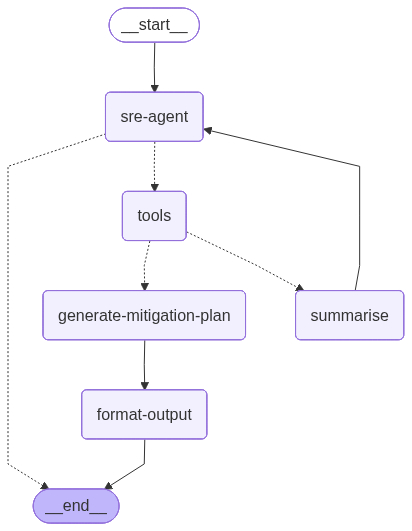

In [81]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Build the graph
builder = StateGraph(SREAgentState)

# Add nodes
builder.add_node("sre-agent", sreAgent)
builder.add_node("tools", ToolNode(tools_with_completion)) # Tool node is executing the tool called in the previous message
builder.add_node("summarise", summarise) # Node to reduce the raw data into a schema
builder.add_node("generate-mitigation-plan", mitigation_planner)
builder.add_node("format-output", format_response)

# Add edges
builder.add_edge(START, "sre-agent")

# Conditional edge from sre-agent
builder.add_conditional_edges(
    "sre-agent",
    #Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.
    tools_condition,
)

# After tools, decide whether to summarise or end
def after_tools_condition(state: SREAgentState):
    # If response is filled, investigation is complete (end of the workflow)
    if state.get("response"):
        return "generate-mitigation-plan"
    return "summarise"

builder.add_conditional_edges(
    "tools",
    after_tools_condition,
    {
        "summarise": "summarise",
        "generate-mitigation-plan": "generate-mitigation-plan"
    }
)

# After summarise, continue investigation (go to sre-agent)
builder.add_edge("summarise", "sre-agent")
builder.add_edge("generate-mitigation-plan", "format-output")
builder.add_edge("format-output", END)

# Compile the graph
structured_graph = builder.compile()

# Show the graph
display(Image(structured_graph.get_graph(xray=True).draw_mermaid_png()))

In [82]:
import time

async def test_structured_graph(graph, app_summary:str, human_message: str = "", trace_name: str = None):
    """Test the structured graph with SREAgentState"""
    # Create initial state with SREAgentState structure
    initial_state = {
        "messages": [HumanMessage(content=human_message)] if human_message else [],
        "insights": [],
        "prev_steps": [],
        "response": "",
        "final_output" : "",
        "app_summary" : app_summary,
        "mitigation_plan_overview" : "",
        "mitigation_steps" : [],
        "is_already_happened" : False
    }
    
    # Start time tracking
    start_time = time.time()

    # Configuration for the graph execution
    config = {"recursion_limit": 50}
    if trace_name:
        config["run_name"] = trace_name
    
    # Invoke the graph asynchronously
    result = await graph.ainvoke(initial_state, config)

    # Calculate execution time
    execution_time = time.time() - start_time

    return result

In [43]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "SRE structured format agent"

In [44]:
app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC, and starting from the open-source project https://github.com/harlow/go-micro-services. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""

In [83]:
human = ""
structured_result = await test_structured_graph(structured_graph, app_summary, human, experiment_name)

In [84]:
print(structured_result["final_output"])

# 📝 Results of the Analysis

## 🔍 Steps Performed
- Ran kubectl_get to list all pods (kubectl get pods --all-namespaces -o wide).
- Ran kubectl_describe on pod 'geo' in namespace 'test-hotel-reservation' to inspect container state and events.
- Fetched pod logs with kubectl_logs for geo-6b4b89b5f5-v6v72 in namespace test-hotel-reservation (tail=500).
- Ran kubectl_get to list services in namespace test-hotel-reservation (kubectl get services -n test-hotel-reservation -o wide).
- Ran kubectl_get to list services in test-hotel-reservation with output=yaml (kubectl_get services -n test-hotel-reservation -o yaml).
- Ran kubectl_get to list all pods across all namespaces (kubectl get pods --all-namespaces -o wide).

## 💡 Insights Gathered
- test-hotel-reservation/geo pod is in CrashLoopBackOff (0/1) with 16 restarts (last failure ~4m41s ago); other application pods appear Running.
- Pod test-hotel-reservation/geo (geo-6b4b89b5f5-v6v72) is in CrashLoopBackOff: container 'hotel-reserv-geo' re

In [85]:
from IPython.display import Markdown, display

display(Markdown(structured_result["final_output"]))

# 📝 Results of the Analysis

## 🔍 Steps Performed
- Ran kubectl_get to list all pods (kubectl get pods --all-namespaces -o wide).
- Ran kubectl_describe on pod 'geo' in namespace 'test-hotel-reservation' to inspect container state and events.
- Fetched pod logs with kubectl_logs for geo-6b4b89b5f5-v6v72 in namespace test-hotel-reservation (tail=500).
- Ran kubectl_get to list services in namespace test-hotel-reservation (kubectl get services -n test-hotel-reservation -o wide).
- Ran kubectl_get to list services in test-hotel-reservation with output=yaml (kubectl_get services -n test-hotel-reservation -o yaml).
- Ran kubectl_get to list all pods across all namespaces (kubectl get pods --all-namespaces -o wide).

## 💡 Insights Gathered
- test-hotel-reservation/geo pod is in CrashLoopBackOff (0/1) with 16 restarts (last failure ~4m41s ago); other application pods appear Running.
- Pod test-hotel-reservation/geo (geo-6b4b89b5f5-v6v72) is in CrashLoopBackOff: container 'hotel-reserv-geo' repeatedly terminates with Exit Code 2 (RestartCount 16) and fails shortly after start; image pulls succeed — likely an application runtime error.
- Pod geo (geo-6b4b89b5f5-v6v72) is panicking during database initialization: it reads DB URL mongodb-geo:27777 and logs “no reachable servers”, causing an immediate crash and the CrashLoopBackOff.
- Service 'mongodb-geo' exists (ClusterIP 10.96.103.247) and exposes port 27017, while the geo pod is attempting to connect to mongodb-geo:27777 — a port mismatch that likely causes the "no reachable servers" error and the pod CrashLoopBackOff.
- The mongodb-geo Service in namespace test-hotel-reservation exposes port 27017 (ClusterIP 10.96.103.247), confirming the geo pod’s attempt to connect to mongodb-geo:27777 is a port mismatch and is causing the "no reachable servers" error.
- The cluster pod listing shows mongodb-geo is Running (10.244.1.14) while test-hotel-reservation/geo remains in CrashLoopBackOff with its restart count increased to 17 — the DB pod is healthy, reinforcing that the geo crash is due to a configuration/connection issue (e.g., the observed port mismatch) rather than the database being down.

## 🚨 Final Report (Root Cause)
> Diagnosis:
The geo service pod is crashing (CrashLoopBackOff) because it is trying to connect to MongoDB at mongodb-geo:27777, while the mongodb-geo Service is exposing port 27017. This port mismatch prevents the geo process from reaching the database, producing “no reachable servers” errors, causing the app to panic during DB initialization and exit (Exit Code 2).

Reasoning:
Observations and reasoning:
- Geo pod (test-hotel-reservation/geo) is in CrashLoopBackOff with many restarts and container exit code 2, indicating an application runtime error during startup.
- Geo container logs show it attempts to read DB URL mongodb-geo:27777 and logs “no reachable servers” while initializing the database, leading to immediate termination.
- kubectl get services shows a Service named mongodb-geo in namespace test-hotel-reservation with ClusterIP 10.96.103.247 and port 27017 (the default MongoDB port).
- The mongodb-geo backend pod is Running (10.244.1.14), so the database itself is healthy and reachable at the correct port; the problem is that the geo pod is using the wrong port (27777) to connect to it.
- Because the geo process cannot connect to MongoDB on the incorrect port, it panics during initialization and the container exits repeatedly, causing the CrashLoopBackOff.

Conclusion: This is a configuration issue (port mismatch) between the geo application’s MongoDB connection string and the mongodb-geo Service port, not an actual database outage.

## 🛠️ Mitigation Plan Strategy
The geo app is failing because it tries to connect on port 27777 while the MongoDB Service exposes 27017. Add a temporary port 27777 on the Service to restore connectivity quickly, then permanently fix the geo app configuration to use port 27017 and remove the temporary Service change.

## 📋 Detailed Mitigation Steps
1. Overview: The geo app is configured to connect to mongodb-geo:27777 while the mongodb-geo Service exposes port 27017. This is a config mismatch causing the geo pods to CrashLoopBackOff. Plan: apply a fast temporary workaround (add port 27777 to the Service) to restore service, then implement the permanent fix (correct the app config to use 27017) and remove the workaround.
2. Immediate (fastest) workaround — add Service port 27777 (temporary): kubectl patch svc mongodb-geo -n test-hotel-reservation --type='json' -p='[{"op":"add","path":"/spec/ports/-","value":{"name":"mongo-alt","protocol":"TCP","port":27777,"targetPort":27017}}]'. Alternatively: kubectl edit svc mongodb-geo -n test-hotel-reservation and add a port entry (name: mongo-alt, port: 27777, targetPort: 27017, protocol: TCP).
3. Verify workaround: kubectl get svc mongodb-geo -n test-hotel-reservation -o yaml; kubectl get pods -n test-hotel-reservation --watch; kubectl logs -n test-hotel-reservation <geo-pod-name> --follow to confirm geo connects and stops crashing.
4. Optional quick restart of geo after adding the service port (if geo does not auto-retry): kubectl rollout restart deployment/geo -n test-hotel-reservation.
5. Permanent fix — identify where the geo app gets its MongoDB connection info: kubectl get deploy geo -n test-hotel-reservation -o yaml; kubectl describe deploy geo -n test-hotel-reservation; inspect ConfigMaps/Secrets: kubectl get configmap -n test-hotel-reservation; kubectl get secret -n test-hotel-reservation.
6. Permanent fix — update app configuration to use port 27017: If env var (example MONGO_URL), run kubectl set env deployment/geo -n test-hotel-reservation MONGO_URL='mongodb://mongodb-geo:27017/<db>' (replace variable and DB name as appropriate). If ConfigMap, kubectl edit configmap <name> -n test-hotel-reservation and update the connection string, then restart the deployment.
7. If you manage manifests via Helm/Kustomize/GitOps: update chart/values or repo manifest with the correct port (27017) and deploy via CI to ensure changes are persisted.
8. Verify permanent fix: kubectl rollout status deployment/geo -n test-hotel-reservation; kubectl get pods -n test-hotel-reservation; kubectl logs -n test-hotel-reservation <geo-pod-name> --tail=200 and confirm no 'no reachable servers' errors and stable Running state.
9. Cleanup workaround: after the app config is fixed and verified, remove the temporary 27777 port from the mongodb-geo Service via kubectl edit svc mongodb-geo -n test-hotel-reservation (or kubectl patch to remove the port entry).
10. Rollback plan: if the config change causes regressions, revert to the previous config from source control or run kubectl rollout undo deployment/geo -n test-hotel-reservation. If needed, re-add the 27777 Service port as a short-lived fallback.
11. Verification checklist: geo pods remain Running (no CrashLoopBackOff); geo logs show successful DB connection; kubectl describe svc mongodb-geo shows only expected ports; test connectivity from a debug pod (kubectl run -n test-hotel-reservation --rm -it --restart=Never debug --image=busybox -- sh, then nc -vz mongodb-geo 27017).
12. Post-incident actions: update canonical manifests (Helm/Git) with the corrected connection string; create a short postmortem (root cause, timeline, fix, preventative actions); add CI/lint rule or a deployment check to detect port mismatches; consider a readiness probe policy for geo if appropriate.
13. Risk considerations: Modifying Service to add a port is low risk but hides root cause — treat as temporary. Changing app config triggers a rolling restart of geo pods and may cause brief downtime. Validate changes through your CI/QA path when possible.
14. Estimated timeline: Workaround (add service port + verify) ~5–15 minutes. Permanent fix (identify source, update manifests, deploy via CI and verify) ~15–60 minutes depending on pipelines and approvals.


In [86]:
for step in structured_result["prev_steps"]:
    print(step)

Ran kubectl_get to list all pods (kubectl get pods --all-namespaces -o wide).
Ran kubectl_describe on pod 'geo' in namespace 'test-hotel-reservation' to inspect container state and events.
Fetched pod logs with kubectl_logs for geo-6b4b89b5f5-v6v72 in namespace test-hotel-reservation (tail=500).
Ran kubectl_get to list services in namespace test-hotel-reservation (kubectl get services -n test-hotel-reservation -o wide).
Ran kubectl_get to list services in test-hotel-reservation with output=yaml (kubectl_get services -n test-hotel-reservation -o yaml).
Ran kubectl_get to list all pods across all namespaces (kubectl get pods --all-namespaces -o wide).


In [87]:
for insight in structured_result["insights"]:
    print(insight)

test-hotel-reservation/geo pod is in CrashLoopBackOff (0/1) with 16 restarts (last failure ~4m41s ago); other application pods appear Running.
Pod test-hotel-reservation/geo (geo-6b4b89b5f5-v6v72) is in CrashLoopBackOff: container 'hotel-reserv-geo' repeatedly terminates with Exit Code 2 (RestartCount 16) and fails shortly after start; image pulls succeed — likely an application runtime error.
Pod geo (geo-6b4b89b5f5-v6v72) is panicking during database initialization: it reads DB URL mongodb-geo:27777 and logs “no reachable servers”, causing an immediate crash and the CrashLoopBackOff.
Service 'mongodb-geo' exists (ClusterIP 10.96.103.247) and exposes port 27017, while the geo pod is attempting to connect to mongodb-geo:27777 — a port mismatch that likely causes the "no reachable servers" error and the pod CrashLoopBackOff.
The mongodb-geo Service in namespace test-hotel-reservation exposes port 27017 (ClusterIP 10.96.103.247), confirming the geo pod’s attempt to connect to mongodb-geo

In [88]:
print(structured_result["response"])

Diagnosis:
The geo service pod is crashing (CrashLoopBackOff) because it is trying to connect to MongoDB at mongodb-geo:27777, while the mongodb-geo Service is exposing port 27017. This port mismatch prevents the geo process from reaching the database, producing “no reachable servers” errors, causing the app to panic during DB initialization and exit (Exit Code 2).

Reasoning:
Observations and reasoning:
- Geo pod (test-hotel-reservation/geo) is in CrashLoopBackOff with many restarts and container exit code 2, indicating an application runtime error during startup.
- Geo container logs show it attempts to read DB URL mongodb-geo:27777 and logs “no reachable servers” while initializing the database, leading to immediate termination.
- kubectl get services shows a Service named mongodb-geo in namespace test-hotel-reservation with ClusterIP 10.96.103.247 and port 27017 (the default MongoDB port).
- The mongodb-geo backend pod is Running (10.244.1.14), so the database itself is healthy and

In [92]:
print(structured_result["mitigation_plan_overview"])

The geo app is failing because it tries to connect on port 27777 while the MongoDB Service exposes 27017. Add a temporary port 27777 on the Service to restore connectivity quickly, then permanently fix the geo app configuration to use port 27017 and remove the temporary Service change.


In [89]:
for message in structured_result["messages"]:
    message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  kubectl_get (call_nF6ND7r9RjhZ9CU9xZetWAa8)
 Call ID: call_nF6ND7r9RjhZ9CU9xZetWAa8
  Args:
    resourceType: pods
    name: 
    namespace: default
    allNamespaces: True
    output: wide
================================= Tool Message =================================
Name: kubectl_get

NAMESPACE                NAME                                                       READY   STATUS             RESTARTS         AGE   IP            NODE                 NOMINATED NODE   READINESS GATES
default                  wrk2-job-bhn4r                                             0/1     Completed          0                66m   10.244.1.31   kind-worker          <none>           <none>
kube-system              coredns-668d6bf9bc-68zct                                   1/1     Running            0                84m   10.244.0.2    kind-control-plane   <none>           <none>
kube-system              co